In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/Users/bhojraj/Downloads/TSLA.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [6]:
# taking Close column

In [7]:
df1=df.reset_index()['Close']

In [8]:
df1.head()

0    4.778
1    4.766
2    4.392
3    3.840
4    3.222
Name: Close, dtype: float64

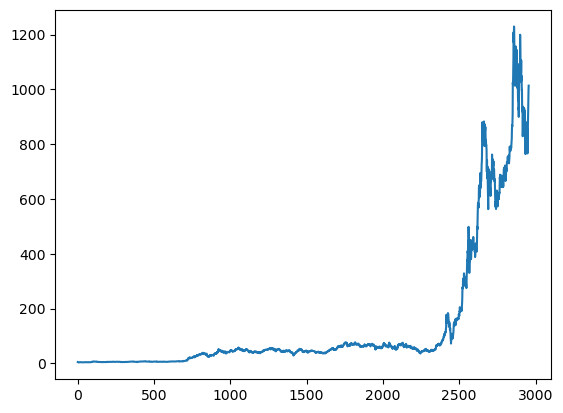

In [9]:
plt.plot(df1)

In [10]:
# LSTM are scale sensetive , so we need to scalethe data, for this we will use MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1.shape

(2956, 1)

# Split the dataset into Train and Test data

In [13]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

In [14]:
training_size

1921

In [15]:
test_size

1035

In [16]:
train_data = df1[0:training_size,:]
test_data= df1[training_size:len(df1),:1]

In [17]:
# convert the array of values into dataset metrix(sequential data)

In [18]:
import numpy as np
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


In [19]:
# reshape into X= t,t+1,t+2,t+3 and y = t+4

In [20]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape),print(y_train.shape)

(1820, 100)
(1820,)


(None, None)

In [22]:
print(X_test.shape),print(y_test.shape)

(934, 100)
(934,)


(None, None)

In [23]:
# Reshape input to be [samples,time_step,features] which are required for LSTM

In [24]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [25]:
# create the LSTM model

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dense,Dropout

In [27]:
model = Sequential()

In [28]:
model.add(LSTM(50,return_sequences = True,input_shape = (100,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))


model.add(Dense(1))


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [30]:
# compile the model

In [31]:
model.compile(loss ='mean_squared_error',optimizer = 'adam')

In [32]:
model.fit(X_train,y_train,epochs = 10,validation_data =(X_test,y_test))

Epoch 1/10
57/57 [==============================] - 5s 59ms/step - loss: 1.1166e-04 - val_loss: 0.0109
Epoch 2/10
57/57 [==============================] - 3s 53ms/step - loss: 1.4529e-05 - val_loss: 0.0090
Epoch 3/10
57/57 [==============================] - 3s 54ms/step - loss: 1.4886e-05 - val_loss: 0.0066
Epoch 4/10
57/57 [==============================] - 3s 54ms/step - loss: 1.2255e-05 - val_loss: 0.0064
Epoch 5/10
57/57 [==============================] - 3s 54ms/step - loss: 1.0332e-05 - val_loss: 0.0058
Epoch 6/10
57/57 [==============================] - 3s 54ms/step - loss: 1.1232e-05 - val_loss: 0.0056
Epoch 7/10
57/57 [==============================] - 3s 54ms/step - loss: 1.1962e-05 - val_loss: 0.0054
Epoch 8/10
57/57 [==============================] - 3s 54ms/step - loss: 1.1269e-05 - val_loss: 0.0062
Epoch 9/10
57/57 [==============================] - 3s 54ms/step - loss: 9.3625e-06 - val_loss: 0.0038
Epoch 10/10
57/57 [==============================] - 3s 54ms/step - loss:

In [34]:
# Predict the test data

In [35]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

30/30 [==============================] - 0s 11ms/step


In [36]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [37]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

40.92249734066319

In [38]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))


413.32490925870025

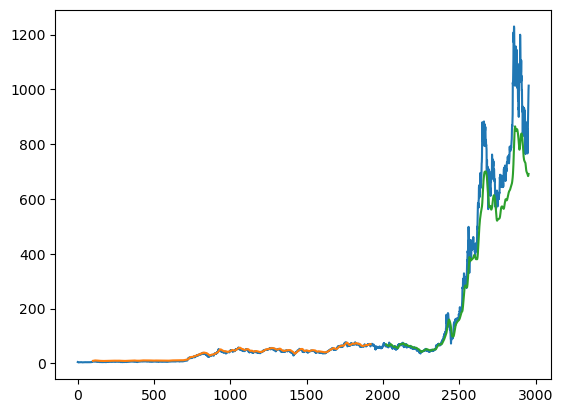

In [39]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
len(test_data)

1035

In [48]:
x_input=test_data[935:].reshape(1,-1)
x_input.shape

(1, 100)

In [49]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [50]:
temp_input

[0.9826206909239019,
 0.952793941393932,
 0.986916610103799,
 1.0,
 0.9936253778004788,
 0.9454085256622052,
 0.8317423857515867,
 0.867976296302267,
 0.864357025157417,
 0.8398288285680211,
 0.8235011102514468,
 0.8571998784228281,
 0.8851436559242843,
 0.8911513957210945,
 0.9243122295279268,
 0.9404605363964474,
 0.9014632144693302,
 0.9071448699059096,
 0.879364185124612,
 0.9242551119423895,
 0.9305889369145924,
 0.8900264680979011,
 0.8815487638290949,
 0.824789030329874,
 0.8199306966556807,
 0.8547707119933123,
 0.868799618064653,
 0.8156836847497492,
 0.8264683113104361,
 0.7852047656841558,
 0.7787650161173748,
 0.7930140314143249,
 0.7530140268168112,
 0.7576197116290442,
 0.7310209717915526,
 0.7624780950281189,
 0.8198165617495309,
 0.8672019323538899,
 0.8891623482930348,
 0.8847034366579036,
 0.8828448428638888,
 0.8699245456878464,
 0.8588710004470235,
 0.9754391651396523,
 0.9345261334633068,
 0.8844181495249913,
 0.86532701983198,
 0.8345628144486362,
 0.8599632897992

In [51]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.57483315]
101
1 day input [0.95279394 0.98691661 1.         0.99362538 0.94540853 0.83174239
 0.8679763  0.86435703 0.83982883 0.82350111 0.85719988 0.88514366
 0.8911514  0.92431223 0.94046054 0.90146321 0.90714487 0.87936419
 0.92425511 0.93058894 0.89002647 0.88154876 0.82478903 0.8199307
 0.85477071 0.86879962 0.81568368 0.82646831 0.78520477 0.77876502
 0.79301403 0.75301403 0.75761971 0.73102097 0.7624781  0.81981656
 0.86720193 0.88916235 0.88470344 0.88284484 0.86992455 0.858871
 0.97543917 0.93452613 0.88441815 0.86532702 0.83456281 0.85996329
 0.86508253 0.89917256 0.83831264 0.85302625 0.83745668 0.80904014
 0.80954554 0.76685551 0.75552474 0.74606888 0.76156507 0.67327488
 0.68733642 0.7610026  0.75654369 0.73568367 0.72384756 0.75007946
 0.73705319 0.74900344 0.75715506 0.73477886 0.6984634  0.71131036
 0.74935396 0.75013653 0.71179128 0.69600159 0.66710414 0.62024044
 0.65018137 0.65759933 0.70696553 0.70202565 0.71467698 0.68158138
 0.68076622 0.65328714 0.66944365 0.

10 day output [[0.52170664]]
11 day input [0.85719988 0.88514366 0.8911514  0.92431223 0.94046054 0.90146321
 0.90714487 0.87936419 0.92425511 0.93058894 0.89002647 0.88154876
 0.82478903 0.8199307  0.85477071 0.86879962 0.81568368 0.82646831
 0.78520477 0.77876502 0.79301403 0.75301403 0.75761971 0.73102097
 0.7624781  0.81981656 0.86720193 0.88916235 0.88470344 0.88284484
 0.86992455 0.858871   0.97543917 0.93452613 0.88441815 0.86532702
 0.83456281 0.85996329 0.86508253 0.89917256 0.83831264 0.85302625
 0.83745668 0.80904014 0.80954554 0.76685551 0.75552474 0.74606888
 0.76156507 0.67327488 0.68733642 0.7610026  0.75654369 0.73568367
 0.72384756 0.75007946 0.73705319 0.74900344 0.75715506 0.73477886
 0.6984634  0.71131036 0.74935396 0.75013653 0.71179128 0.69600159
 0.66710414 0.62024044 0.65018137 0.65759933 0.70696553 0.70202565
 0.71467698 0.68158138 0.68076622 0.65328714 0.66944365 0.69762376
 0.68077438 0.64576316 0.62213978 0.65109435 0.68234763 0.70791926
 0.73546362 0.748318

21 day output [[0.4302472]]
22 day input [0.88154876 0.82478903 0.8199307  0.85477071 0.86879962 0.81568368
 0.82646831 0.78520477 0.77876502 0.79301403 0.75301403 0.75761971
 0.73102097 0.7624781  0.81981656 0.86720193 0.88916235 0.88470344
 0.88284484 0.86992455 0.858871   0.97543917 0.93452613 0.88441815
 0.86532702 0.83456281 0.85996329 0.86508253 0.89917256 0.83831264
 0.85302625 0.83745668 0.80904014 0.80954554 0.76685551 0.75552474
 0.74606888 0.76156507 0.67327488 0.68733642 0.7610026  0.75654369
 0.73568367 0.72384756 0.75007946 0.73705319 0.74900344 0.75715506
 0.73477886 0.6984634  0.71131036 0.74935396 0.75013653 0.71179128
 0.69600159 0.66710414 0.62024044 0.65018137 0.65759933 0.70696553
 0.70202565 0.71467698 0.68158138 0.68076622 0.65328714 0.66944365
 0.69762376 0.68077438 0.64576316 0.62213978 0.65109435 0.68234763
 0.70791926 0.73546362 0.74831869 0.80767879 0.81186057 0.82393312
 0.57483315 0.58034742 0.58238316 0.58087528 0.57634813 0.56952405
 0.56111431 0.5517228

In [52]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [53]:
len(df1)

2956

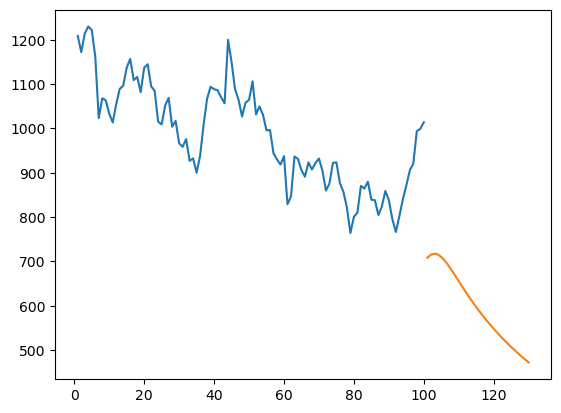

In [54]:
plt.plot(day_new,scaler.inverse_transform(df1[2856:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

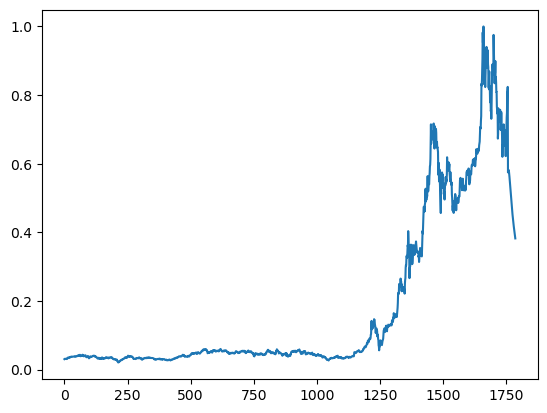

In [55]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [56]:
df3=scaler.inverse_transform(df3).tolist()

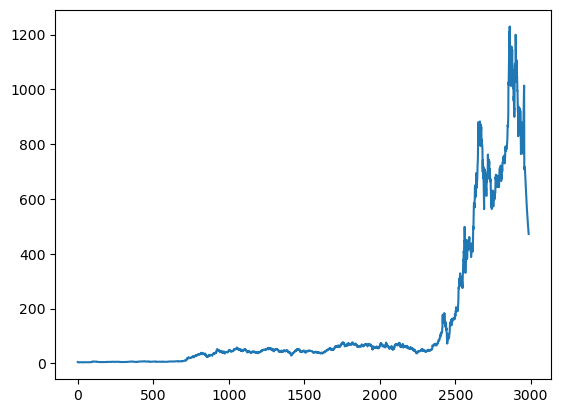

In [57]:
plt.plot(df3)